# Studies of data reuse: Excitability of mouse hippocampal CA1 pyramidal neurons during sustained (500 ms) strong depolarization

**Liam Chan-kin and Andrew P. Davison**

Paris-Saclay Institute of Neuroscience, CNRS, Université Paris-Saclay, France.

August 2024

----

In this notebook we will look more closely at the EBRAINS dataset "[Excitability of mouse hippocampal CA1 pyramidal neurons during sustained (500 ms) strong depolarization (v1)](https://search.kg.ebrains.eu/#07554ebd-95a2-46f0-8065-d961d56ce098)", contributed by Machhindra Garad while at Otto-von-Guericke University, Magdeburg, Germany and Volkmar Lessmann from the Center for Behavioral Brain Sciences (CBBS), Magdeburg, Germany.

As we can see from the dataset description,

<i>This dataset provides an analysis of electrophysiological feature often observed in recordings from mouse CA1 pyramidal cells that has so far been ignored by experimentalists and modelers. It consists of a large and dynamic increase in the depolarization baseline (i.e., the minimum value of the membrane potential between successive action potentials during a sustained depolarizing input) in response to strong somatic current injections.</i>
More information is available in the [Data Descriptor](https://search.kg.ebrains.eu/instances/07554ebd-95a2-46f0-8065-d961d56ce098).

This dataset forms part of the results reported in Bianchi, D., Migliore, R., Vitale, P., Garad, M., Pousinha, P. A., Marie, H., Lessmann, V., & Migliore, M. (2022). Membrane electrical properties of mouse hippocampal CA1 pyramidal neurons during strong inputs. *Biophysical Journal*, **121(4), 644–657**. https://doi.org/10.1016/j.bpj.2022.01.002

In this notebook we will demonstrate how to access the data files and the metadata from this study, and how these data can be analysed and visualised, with the goal of reproducing some of the figures from the article. 

# Downloading the data

Please note that this is a 5.3 MB dataset. Over a slow connection, this could take a long time to download. If running this notebook on a shared resource such as the EBRAINS lab, you may need to delete the downloaded data after use, to avoid taking up too much disk space.

To download the data, we first search for the dataset in the EBRAINS Knowledge Graph using the [fairgraph](https://fairgraph.readthedocs.io/) tool, then download a zip file, and unzip it.

In [1]:
import os
import warnings
import zipfile

from fairgraph import KGClient
import fairgraph.openminds.core as omcore

omcore.set_error_handling(None)
warnings.filterwarnings('ignore')

#token = clb_oauth.get_token()
token = "eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJfNkZVSHFaSDNIRmVhS0pEZDhXcUx6LWFlZ3kzYXFodVNJZ1RXaTA1U2k0In0.eyJleHAiOjE3MjY3MzQ5MzgsImlhdCI6MTcyNjEzMDQzMiwiYXV0aF90aW1lIjoxNzI2MTMwMTM4LCJqdGkiOiI0ODhhMmQyOS01YjNlLTRjYzctYTFhNi1iNzM5NTE3YzUxZWUiLCJpc3MiOiJodHRwczovL2lhbS5lYnJhaW5zLmV1L2F1dGgvcmVhbG1zL2hicCIsImF1ZCI6WyJqdXB5dGVyaHViIiwidHV0b3JpYWxPaWRjQXBpIiwieHdpa2kiLCJqdXB5dGVyaHViLWpzYyIsInRlYW0iLCJwbHVzIiwiZ3JvdXAiXSwic3ViIjoiYzU0ODdjNWItYjVkNi00MWIxLWI1MDYtNzczYTA0YTc0ZDAzIiwidHlwIjoiQmVhcmVyIiwiYXpwIjoibW9kZWwtdmFsaWRhdGlvbi1zZXJ2aWNlIiwibm9uY2UiOiJsQzB5SFBYeTE2OU55MldEelVMVSIsInNlc3Npb25fc3RhdGUiOiI1NzdhOWMyMS1mYjJjLTQ4ZGUtYjZmNS0yZTEwMzkxZDhmZWQiLCJzY29wZSI6InByb2ZpbGUgY29sbGFiLmRyaXZlIGNsYi53aWtpLndyaXRlIHJvbGVzIG9wZW5pZCBncm91cCBjbGIud2lraS5yZWFkIHRlYW0iLCJzaWQiOiI1NzdhOWMyMS1mYjJjLTQ4ZGUtYjZmNS0yZTEwMzkxZDhmZWQiLCJnZW5kZXIiOiIwIiwibmFtZSI6IkFuZHJldyBEYXZpc29uIiwibWl0cmVpZC1zdWIiOiIyMDcxNDkiLCJwcmVmZXJyZWRfdXNlcm5hbWUiOiJhZGF2aXNvbiIsImdpdmVuX25hbWUiOiJBbmRyZXciLCJmYW1pbHlfbmFtZSI6IkRhdmlzb24ifQ.1z64VpEyFcTN42ZLm3XQiVwTG7uZnH8_LFaLhCPpwGUPzJqECjW2GkS7j6cmq3vYpkoLpS-j06ZEr0bED-N_xjFPJ8NWKofI_y5P-h2hMrugnSSIRQQBtYs5H-z5k4v4qLY_GeNDd02p-AxijE2Uw1niN-W9U71hRaufbbJH7KSEcMhrL3PMnfgf0ySxNijhifGLoISCfBp-_GpO5nvqLAbsJa7amvExEVndlU-IdYAaJWO454ADEO64tIIu8vsilE2WqxWrPdrTbrDiKGCBYooQogAY0_PnVJiITy9VHiYSuBhtXylgMdo3e5DLkNoN-di7Y8adcQ8NY76oPJORyg"
kg_client = KGClient(host="core.kg.ebrains.eu", token=token)

In [2]:
dataset_version_doi = "10.25493/VAV5-BXU"

dataset_versions = omcore.DatasetVersion.list(
    kg_client, 
    digital_identifier__identifier=dataset_version_doi,
    #follow_links={"has_parts": {}},
    follow_links={"repository": {"files": {}}},
    scope="any"
)

assert len(dataset_versions) == 1  # the DOI should be for a single, specific version

dataset_version = dataset_versions[0]
assert dataset_version.full_name == "Excitability of mouse hippocampal CA1 pyramidal neurons during sustained (500 ms) strong depolarization"

if not os.path.exists("downloads"):  # only download the dataset if it hasn't been downloaded previously
    dataset_path = dataset_version.download("downloads", kg_client, accept_terms_of_use=True)[0]
else:
    dataset_path = "downloads/d-cc88a377-b456-4673-a449-07b0e7960ffd.zip"
with zipfile.ZipFile(dataset_path, "r") as z:
    z.extractall("downloads")

Cannot yet handle case where self.path is a list: Property(name='describes', types=(<class 'fairgraph.openminds.core.research.behavioral_protocol.BehavioralProtocol'>, <class 'fairgraph.openminds.core.research.protocol.Protocol'>, <class 'fairgraph.openminds.ephys.device.electrode_array_usage.ElectrodeArrayUsage'>, <class 'fairgraph.openminds.ephys.device.electrode_usage.ElectrodeUsage'>, <class 'fairgraph.openminds.ephys.device.pipette_usage.PipetteUsage'>, <class 'fairgraph.openminds.specimen_prep.device.slicing_device_usage.SlicingDeviceUsage'>), path='['^vocab:describedIn', '^vocab:metadataLocation']', required=False, multiple=True)
Cannot yet handle case where self.path is a list: Property(name='is_output_of', types=(<class 'fairgraph.openminds.computation.data_analysis.DataAnalysis'>, <class 'fairgraph.openminds.computation.data_copy.DataCopy'>, <class 'fairgraph.openminds.computation.generic_computation.GenericComputation'>, <class 'fairgraph.openminds.computation.model_validati

# Retrieving the metadata

Metadata are stored in the Knowledge Graph. Some of the metadata is part of the `dataset_version` object we've already retrieved, but for other metadata we need to follow links in the graph. 

In [3]:
print(dataset_version.description)

In this work, we highlight an electrophysiological feature often observed in recordings from mouse CA1 pyramidal cells that has so far been ignored by experimentalists and modelers. It consists of a large and dynamic increase in the depolarization baseline (i.e., the minimum value of the membrane potential between successive action potentials during a sustained depolarizing input) in response to strong somatic current injections. Such an increased sustained depolarization can directly affect neurotransmitter release properties and, more generally, the efficacy of synaptic transmission. However, it cannot be explained by any currently available conductance-based computational model.

Here, we provide the original data describing and modeling the depolarization baseline (DBL) phenomenon and descriptions of the methods used, as reported in the related publication (Bianchi et al., 2022). This dataset entails the experiments generated in laboratory 2.


In [4]:
from fairgraph.utility import as_list

def show_linked_metadata(property):
    items = []
    for link in as_list(property):
        item = link.resolve(kg_client)
        items.append(item.name)
    return items

In [5]:
print("Data types:              ", show_linked_metadata(dataset_version.data_types))
print("Experimental approaches: ", show_linked_metadata(dataset_version.experimental_approaches))
print("Keywords:                ", show_linked_metadata(dataset_version.keywords))
print("Study targets:           ", show_linked_metadata(dataset_version.study_targets))
print("Techniques:              ", show_linked_metadata(dataset_version.techniques))

Data types:               ['experimental data', 'raw data']
Experimental approaches:  ['electrophysiology']
Keywords:                 ['intrinsic excitability', 'depolarization baseline']
Study targets:            ['hippocampus CA1 pyramidal neuron']
Techniques:               ['whole cell patch clamp']


We will retrieve more metadata in the course of our exploration of the data.

## Exploring and visualizing the data

Of the two laboratories whose data are shown in the associated paper (Bianchi et al., 2022), only the data from "Laboratory 2" is contained in this dataset.

The dataset contains a number of files with the extension ".abf". There are 2 subjects with different cell states.

We know from the dataset metadata that these are electrophysiology data, and more specifically that they were obtained with the whole cell patch clamp technique. We will therefore use the [Neo library](https://neo.readthedocs.io/) to read the data files, since it is able to read data from a large number of electrophysiology file formats.

In [6]:
from glob import glob
import numpy as np
from neo import get_io

Neo loads data into a hierarchical structure: Blocks contain Segments, which contain the actual data.

Let's look at the structure of the first three files:

In [7]:
for file_path in glob("downloads/*.ABF")[:3]:
    io = get_io(file_path)
    print(io)

ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable


AxonIO: downloads/170518_1a.ABF
nb_block: 1
nb_segment:  [1]
signal_streams: [Signals (chans: 1)]
signal_channels: []
spike_channels: []
event_channels: [Tag]

AxonIO: downloads/170529_3a.ABF
nb_block: 1
nb_segment:  [1]
signal_streams: [Signals (chans: 1)]
signal_channels: []
spike_channels: []
event_channels: [Tag]

AxonIO: downloads/170529_2e.ABF
nb_block: 1
nb_segment:  [1]
signal_streams: [Signals (chans: 1)]
signal_channels: []
spike_channels: []
event_channels: [Tag]



These all have a consistent structure: they're in Axon format, and contain a single block containing 1 segment.
We know from the associated paper that current pulses of increasing intensity were injected into the neurons, in steps of 50 pA from 0 to 450 pA. We can also retrieve this information directly from the Knowledge Graph:

In [8]:
import json
import fairgraph.openminds.stimulation as stim

stimulation_activities = [
    activity.resolve(kg_client, scope="any", follow_links={"stimuli": {}}) 
    for activity in dataset_version.has_parts 
    if stim.StimulationActivity in activity.classes
]
stimulus = stimulation_activities[0].stimuli.resolve(kg_client, scope="any")

Property 'protocols' is required but was not provided.
Property 'protocols' is required but was not provided.
Property 'protocols' is required but was not provided.
Property 'protocols' is required but was not provided.
Property 'protocols' is required but was not provided.
Property 'protocols' is required but was not provided.
Property 'protocols' is required but was not provided.


In [9]:
print(stimulus.description, "\n")
stimulus_config = json.loads(stimulus.specifications.resolve(kg_client, scope="any").configuration)
stimulus_config

The intrinsic excitability of CA1 pyramidal neurons was assessed by action potential frequency readout in response to 0–450 pA (50-pA increments, repeated five times for each current injection at 5-s intervals) depolarizing somatic current injections for 500-ms duration in current-clamp mode from the endogenous resting membrane potential. 



{'onset': 100,
 'duration': 500,
 'interval': 700,
 'amplitudes': [0, 50, 100, 150, 200, 250, 300, 350, 400, 450],
 'time_units': 'ms',
 'amplitude_units': 'pA'}

So it seems likely that the segment contains the responses to all current pulses for a given repeat. We will assume at this point that all the signals are similar, and take a closer look at one of them.

In [10]:
data = get_io("downloads/170529_1b.ABF").read(lazy=True)
example_signal = data[0].segments[0].analogsignals[0].load()
example_signal

ignoring buggy nTelegraphEnable


AnalogSignal with 1 channels of length 70000; units mV; datatype float32
name: 'Signals'
annotations: {'stream_id': '0'}
sampling rate: 10000.0 Hz
time: 0.0 s to 7.0 s

In patch clamp recording, it often happens that raw recorded traces need to be corrected because of the liquid junction potential.
For more information on the liquid junction potential, we can look this term up in the EBRAINS Knowledge Graph:

In [11]:
import fairgraph.openminds.controlled_terms as terms

ljp_term = terms.MeasuredQuantity.by_name("liquid junction potential", kg_client)
ljp_term.definition

'A potential difference that develops when two solutions of electrolytes of different concentrations are in contact with each other.'

We can also retrieve the measured value of the liquid junction potential from the dataset metadata:

In [12]:
import fairgraph.openminds.ephys as ephys

file_170529_1b = [f for f in dataset_version.repository.files if "170529_1b" in f.name][0]
recording_info = file_170529_1b.is_location_of.resolve(kg_client, scope="any", follow_links={"recorded_with": {}})

In [13]:
import quantities as pq

ljp_unit_name = recording_info.recorded_with.liquid_junction_potential.values.unit.resolve(kg_client).name
ljp_unit = getattr(pq, ljp_unit_name)

In [14]:
ljp_correction = recording_info.recorded_with.liquid_junction_potential.values.value * ljp_unit
ljp_correction

array(-10.) * mV

Now let's plot the data from one of the files:

ignoring buggy nTelegraphEnable


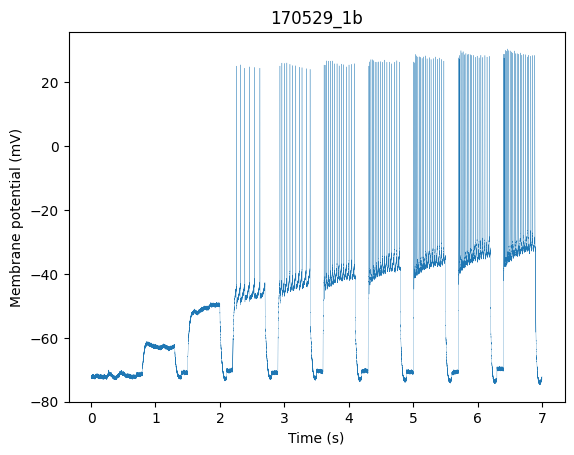

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def plot_data(file_path, title): 
    data = get_io(file_path).read(lazy=True)
    for segment in data[0].segments:
        signal = segment.analogsignals[0].load() + ljp_correction
        plt.plot(signal.times, signal, lw=0.2)
    plt.title(title)
    plt.xlabel(f"Time ({signal.times.units.dimensionality})")
    plt.ylabel(f"Membrane potential ({signal.units.dimensionality})")
    
plot_data("downloads/170529_1b.ABF", title="170529_1b")

## Figure 1

Figure 1 shows the DBL (depolarization baseline) increases with current injection. To get a closer look at the signals, we can slice the signal to get each current injection independently , and plot only the 700 ms around the current injection:

ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable


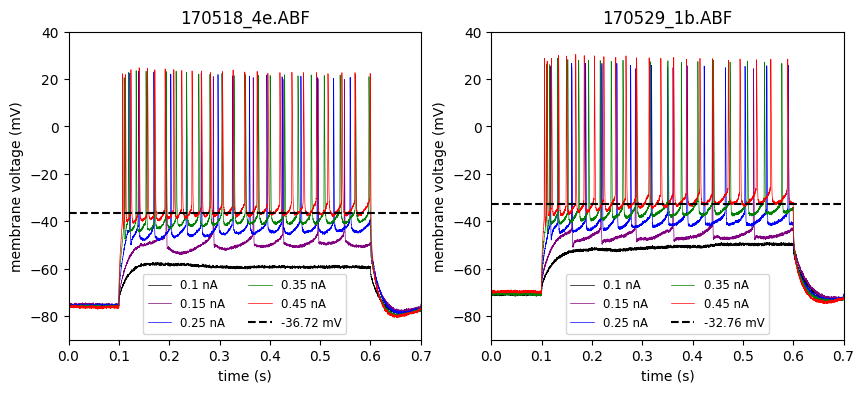

In [16]:
stimulus_interval = stimulus_config["interval"] / 1000  # convert from ms to seconds
current_pulse_amplitudes = stimulus_config["amplitudes"]

def plot_data_zoom(ax, file_path, liquid_junction_potential_correction, show_amplitudes, line_colours, dbl_level):
    # Read the data
    data = get_io(file_path).read(lazy=True)
    # Apply the liquid junction potential correction
    signal = data[0].segments[0].analogsignals[0].load() + liquid_junction_potential_correction
    # Plot the sections of the signal that correspond to specific stimulus amplitudes
    for stimulus_amplitude, colour in zip(show_amplitudes, line_colours):
        index = current_pulse_amplitudes.index(stimulus_amplitude)
        stim_onset = index * stimulus_interval
        ax.plot(signal.times - stim_onset * pq.s, signal, lw=0.5, color=colour, label=f"{stimulus_amplitude/1000} nA")
    # Add a horizontal line indicating the depolarization baseline (DBL)
    ax.axhline(y=dbl_level, color='black', linestyle='--', label=f'{dbl_level} mV')
    # Adjust the figure axes, legend and labels
    ax.set_xlim(0.0, stimulus_interval)
    ax.set_ylim(-90, 40)
    ax.set_xlabel(f"time ({signal.times.units.dimensionality})")
    ax.set_ylabel(f"membrane voltage ({signal.units.dimensionality})")
    ax.legend(loc="lower center", ncol=2, fontsize='small')
    ax.set_title(file_path.split("/")[1])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
dbl_levels = [-36.72, -32.76]  # todo: calculate the DBL levels from the data, here we take the values shown in the paper

for file_path, ax, dbl in zip(("downloads/170518_4e.ABF", "downloads/170529_1b.ABF"), axes, dbl_levels): 
    plot_data_zoom(
        ax,
        file_path=file_path, 
        liquid_junction_potential_correction=ljp_correction,
        show_amplitudes=[100, 150, 250, 350, 450], 
        line_colours=["black", "purple", "blue", "green", "red"],
        dbl_level=dbl
    )

Here is the original Figure 1 Laboratory 2 for comparison (CC-BY licence; see the introduction to this notebook for the citation and links to the original article).

We can see the same results between the original figure and the reproduction. The only difference is the units in the legend, which appear to be incorrect in the original figure.

![fig1](original_fig1_lab2.png "Original Figure 1 Lab2")

### Figure 2
Comparaison of each DBL

To detect DBL and take an average for each current injections. We create some functions to have the derivate equal to 0. Then we filtered the results to have the right value before take an average.

Once we have DBL average for each current injections, we apply the same methods for all the files.

In [17]:
import pandas as pd

# Calcul derivate 
def compute_derivatives(Data_pulse, delta_x=1):
    derivatives = Data_pulse.diff() / delta_x
    return derivatives

# Keep all derivate equal 0
def get_zero_derivative_indices(Data_pulse):
    zero_derivatives = Data_pulse[Data_pulse == 0]
    indices = {col: zero_derivatives[col].dropna().index.tolist() for col in Data_pulse.columns}
    return indices

# Retreive values when derivate equal 0 
def recuperer_valeurs(Data_pulse, indices):
    return Data_pulse.loc[indices]
    
#Keep consecutive value when derivate equal 0
def consec(serie):
    masque = serie == serie.shift(-1)
    masque |= serie == serie.shift(1)
    return serie[masque]
    
#Select the consecutive value
def more_consec(serie_val):
    return [consec(serie) for serie in serie_val]

#Make the means of the value when derivate equal 0 with the consecutive value
def mean_DBL(serie_DBL):
    return [serie.mean() for serie in serie_DBL]


def process_single_file(file_path, current_pulse_amplitudes, delta_x):
    # Lecture du fichier et stockage des valeurs
    reader = get_io(file_path)
    block = reader.read_block()
    signal_analogique = block.segments[0].analogsignals[0]
    # Conversion des valeurs en liste
    signal_numpy = np.array(signal_analogique)
    # Création d'un tableau 
    df = pd.DataFrame(signal_numpy, columns=['Valeurs'])
    # Calcule la durée de chaque stimulus 
    part_size = len(df) // len(current_pulse_amplitudes)
    # Décomposition du segment par rapport au nombre d'impulsion
    data_parts = [df[i*part_size:(i+1)*part_size] for i in range(len(current_pulse_amplitudes))]
    # Création d'un tableau vide
    Data_pulse = pd.DataFrame()
    # Remplissage du tableau avec les segments décomposés
    for i, part in enumerate(data_parts):
        Data_pulse.insert(i, i, data_parts[i]['Valeurs'].tolist())
    # Ajout du temps correcte en index
    times = np.linspace(0, 0.7, len(Data_pulse)) 
    Data_pulse = Data_pulse.set_index(times)
    Data_pulse.columns = current_pulse_amplitudes
    Data_pulse = Data_pulse - 10

    # Calculer les dérivées pour chaque colonne
    derivatives_df = compute_derivatives(Data_pulse, delta_x)

    # Garder uniquement les valeurs égales à 0
    zero_derivatives_df = get_zero_derivative_indices(derivatives_df)

    derivatives_dict = {}
    # Boucle pour extraire et assigner chaque dérivée à une variable nommée
    for index in current_pulse_amplitudes:
        derivatives_dict[f'derivate_{index}'] = zero_derivatives_df[index]

    filtered_derivatives_dict = {}
    for key, lst in derivatives_dict.items():
        filtered_list = [value for value in lst if 0.1 <= value <= 0.6]
        filtered_derivatives_dict[key] = filtered_list

    # Accès aux listes filtrées
    derivate_filtered = {index: filtered_derivatives_dict[f'derivate_{index}'] for index in current_pulse_amplitudes}

    # Utilisation pour chaque liste d'indices
    valeurs = [recuperer_valeurs(Data_pulse[index], derivate_filtered[index]) for index in current_pulse_amplitudes]

    # Conserver les valeurs consécutives
    serie_DBL = more_consec(valeurs)

    # Calculer la moyenne des séries
    moyenne_DBL = mean_DBL(serie_DBL)

    return moyenne_DBL

def process_data(file_paths, current_pulse_amplitudes, delta_x=1):
    results = []
    for file_path in file_paths:
        moyenne_DBL = process_single_file(file_path, current_pulse_amplitudes, delta_x)
        results.append(moyenne_DBL)
    
    # Convertir la liste de résultats en DataFrame
    tab_mean = pd.DataFrame(results, columns=current_pulse_amplitudes).transpose()
    tab_mean.columns = [os.path.basename(file_path) for file_path in file_paths]
    
    return tab_mean

file_paths = glob("downloads/*.ABF")
tab_mean = process_data(file_paths, current_pulse_amplitudes, delta_x=1)
row_mean = tab_mean.iloc[2:].mean(axis=1)

ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring

Now let's plot the average DBL from all the files.

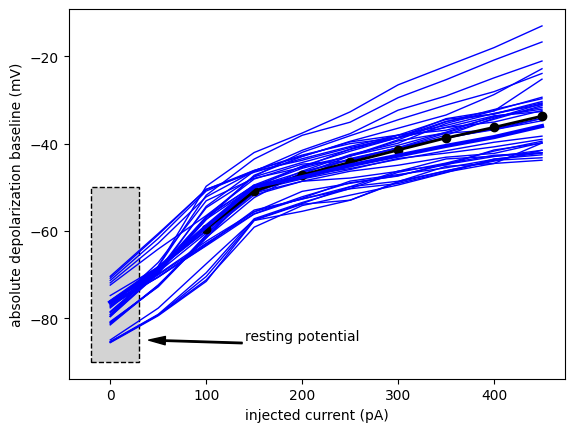

In [18]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()
ax.plot(tab_mean, color='blue',linewidth =1)
ax.plot(row_mean,'o-', color='black', linewidth = 2)
ax.plot(tab_mean['170518_4e.ABF'],color='blue', linewidth=3)

rest_pot = Rectangle((-20, -90), 50, 40, linewidth=1, edgecolor = 'black', facecolor='lightgray', linestyle='--')
ax.add_patch(rest_pot)
ax.annotate('resting potential',xy=(40,-85),xytext=(200, -85),
            arrowprops=dict(facecolor='black',shrink=0,width=1,headwidth=6), 
            fontsize=10, ha='center')

ax.set_yticks(np.arange(-80, 0, 20))
plt.xlabel("injected current (pA)")
plt.ylabel("absolute depolarization baseline (mV)")
plt.show()

Here is the original Figure 2A for comparison (CC-BY licence; see the introduction to this notebook for the citation and links to the original article). We can see differences, on the one hand there are no values ​​from laboratory 1, on the other hand the point at 100 pA is different between the 2 figures. Each blues lines correspond to average DBL to each files, Black lines is the average DBL of all files.
 
![fig2A](original_fig2A.png "Original Figure 2A")

## Summary

In this notebook, we have demonstrated how to access the dataset, and how to read the data files. We have partially reproduced some of the figures from a published paper to which the data contributed.

We leave reproduction of some of the other figures from the paper as an exercise for the reader.